Note: you may need to restart the kernel to use updated packages.

Dataset shape: (1338, 7)

Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Summary statistics:
                 age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.0

<Figure size 600x400 with 0 Axes>

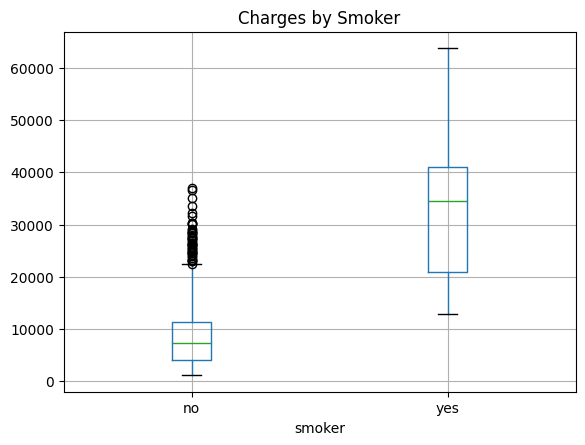

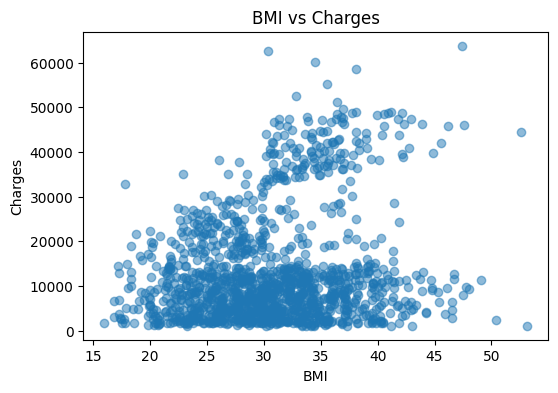

TypeError: got an unexpected keyword argument 'squared'

In [4]:
# insurance_analysis.py
%pip install scikit-learn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os

# Download the dataset if not present
if not os.path.exists("insurance.csv"):
    import urllib.request
    url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
    urllib.request.urlretrieve(url, "insurance.csv")

# Load dataset
df = pd.read_csv("insurance.csv")

print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# ----- Exploratory Data Analysis -----
print("\nMissing values per column:\n", df.isnull().sum())
print("\nSummary statistics:\n", df.describe(include="all"))

# Correlation (numeric features)
print("\nCorrelation with charges:\n", df.corr(numeric_only=True)["charges"])

# Boxplot: smoker vs charges
plt.figure(figsize=(6,4))
df.boxplot(column="charges", by="smoker")
plt.title("Charges by Smoker")
plt.suptitle("")
plt.show()

# Scatter: bmi vs charges
plt.figure(figsize=(6,4))
plt.scatter(df["bmi"], df["charges"], alpha=0.5)
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("BMI vs Charges")
plt.show()

# ----- Data Preparation -----
X = df.drop(columns=["charges"])
y = df["charges"]

numeric_features = ["age","bmi","children"]
categorical_features = ["sex","smoker","region"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# ----- Train / Test split -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----- Linear Regression -----
lr_pipeline = Pipeline([
    ("pre", preprocessor),
    ("model", LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# ----- Random Forest -----
rf_pipeline = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# ----- Evaluation -----
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} performance:")
    print(f"  MAE : {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R²  : {r2:.3f}")

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")

# Cross-validation
cv_lr = cross_val_score(lr_pipeline, X, y, cv=5, scoring="r2")
cv_rf = cross_val_score(rf_pipeline, X, y, cv=5, scoring="r2")
print("\n5-fold CV R²:")
print(f"  Linear Regression: {cv_lr.mean():.3f} ± {cv_lr.std():.3f}")
print(f"  Random Forest    : {cv_rf.mean():.3f} ± {cv_rf.std():.3f}")

# ----- Feature Importances (Random Forest) -----
ohe = rf_pipeline.named_steps["pre"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + ohe_features
importances = rf_pipeline.named_steps["model"].feature_importances_

fi = pd.DataFrame({"feature": feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)
print("\nTop features:\n", fi.head(10))

# ----- Insights -----
print("\nINSIGHTS:")
print("- Smoker status has the largest impact on charges.")
print("- Age and BMI are positively correlated with higher charges.")
print("- Region and sex contribute very little.")
print("- Example: average charges for smokers ≈", df[df.smoker=="yes"]["charges"].mean())
print("           average charges for non-smokers ≈", df[df.smoker=="no"]["charges"].mean())
